<div align="center">
    <h1><p>Business Inteligence</p></h1>
    <h2>SenecaféAlpes</h2>
    
</div>

## Resumen del Caso
SenecaféAlpes, una compañía dedicada a la producción y comercialización de café de alta calidad, enfrenta el desafío de garantizar la uniformidad y trazabilidad de sus granos. La variabilidad en las características morfológicas (tamaño, forma) de los granos puede impactar negativamente tanto los procesos de tueste como la percepción de calidad por parte del consumidor.
Para abordar este problema, la empresa ha utilizado un sistema de visión por computadora para capturar y medir 16 atributos físicos de granos de café de siete variedades distintas. Con estos datos, SenecaféAlpes nos ha contratado como científicos de datos para ejecutar un proyecto de analítica. La tarea principal consiste en aplicar técnicas de agrupación (clustering) para identificar patrones y grupos naturales entre los granos, basándose en sus características morfológicas. El resultado de este análisis debe proporcionar a la empresa conocimientos prácticos para mejorar sus operaciones y estrategia de negocio.
## Objetivos del Proyecto
El proyecto tiene como finalidad generar valor para SenecaféAlpes en tres dimensiones estratégicas. Para ello, se han definido los siguientes objetivos específicos:
**Mejorar el Control de Calidad:**
- Objetivo: Caracterizar morfológicamente los granos de café para estandarizar los procesos de selección y clasificación.
- Acción: Identificar grupos de granos con características físicas homogéneas, lo que permitirá a la empresa definir y aplicar estándares de calidad más precisos y consistentes.
**Optimizar la Estrategia de Mercado:**
- Objetivo: Aprovechar la comprensión de las agrupaciones naturales de las variedades de café para el diseño de nuevos productos.
- Acción: Utilizar los perfiles de los clusters identificados (ej. "granos grandes y alargados" vs. "granos pequeños y redondos") para crear nuevas mezclas de café con perfiles sensoriales y visuales únicos, añadiendo valor y diferenciación en el mercado.
**Innovar en Trazabilidad:**
- Objetivo: Sentar las bases para el desarrollo de sistemas automáticos de identificación de variedades de café.
- Acción: Demostrar que los patrones morfológicos son lo suficientemente distintivos como para separar los granos en grupos coherentes. Esto validaría la viabilidad de futuros sistemas que puedan clasificar granos en tiempo real, reduciendo la dependencia de la evaluación manual, que es más lenta y subjetiva.

## Integrantes
|#| Nombre | Código |
|----|----|----|
|1|Juan Felipe Hernández|202310576|
|2|||
|3|David Elias Forero Cobos|202310499|

---
# 0. Preparación

In [18]:
%pip install pandas numpy matplotlib seaborn scikit-learn -q
%pip install hdbscan gower umap-learn -q


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt, umap
import seaborn as sns
import gower
import hdbscan

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

/Users/david/Documents/BI/Laboratorio2BI/Lab2-bi/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
df = pd.read_csv('data/Datos_SenecaféAlpes.csv', sep=';')

---
# 1. Análisis de calidad de datos


## 1.1 Entendimiento de los datos
**Propósito:**
Comprender qué representa cada columna antes de ver los datos reales, únicamente a partir del diccionario de datos oficial.

**Objetivo:**
Identificar el significado, la definición y el tipo de cada variable; detectar desde el inicio posibles ambigüedades, inconsistencias teóricas o información insuficiente en la documentación.

**Preguntas esenciales:**
¿Sé realmente lo que significa cada variable? ¿Hay definiciones poco claras, ambiguas o contradictorias en el diccionario?

|#| Nombre Columna | Definición | Tipo de dato esperado | ¿Qué indica o facilita? |
|----|-------|-------|-------|-------|
|1|   id    | Código único de cada grano de café      |  int/str     ||
|2|  Área     |   Superficie ocupada por grano medida en pixeles    | int      | El tamaño|
|3| Perímetro      |  Longitud de la circunferencia del grano (no especifica unidades)     | int/float      | La complejidad y continuidad del borde |
|4|   LongitudEjeMayor    |  Distancia entre los extremos mas lejanos del grano (no especifica unidades)     | int/float      | La longitud máxima del grano |
|5|   LongitudEjeMenor    | Distancia más larga de una linea trazada perpendicular al eje mayor (no especifica unidades)      |  int/float     | Ancho máximo transversal del grano |
|6|   RelaciónAspecto    | Relación entre la longitud del eje mayor y el menor. Se calcula con $\frac{LongitudEjeMayor}{LongitudEjeMenor}$   | str      | Si el resultado es >1.3 (Alargado) o si es <=1.3 (Redondeado) |
|7|  Excentricidad     | Relación de la desviación respecto a la eclipse formada por los ejes    | float      | Si el grano tiene forma circular (cercano a 0) o alargada (cercano a 1)|
|8| ÁreaConvexa      | Píxeles contenidos en el polígono convexo más pequeño que abarca el grano     | int      | Que tan irregular es el borde |
|9| DiámetroEquivalente      | Diámetro de un círculo con el mismo área que el grano (no especifica unidades). se calcula con $D=\sqrt\frac{4 A}{\pi}$     | int/float      | Facilita la comparación entre granos de distintas formas |
|10| Medida      | Proporción entre el área del grano y su bounding box      | float      | Que tan bien un grano ocupa su espacio mínimo rectangular |
|11| Solidez      |  Proporción entre el area del grano y el área de su envolvente convexa     |  float     | La regularidad de la forma |
|12| Redondez      | Medida calculada con $\frac{4 \pi A}{P^2}$ (No especifica unidades)     | float      | Que tan circular (cercano a 1) o irregular/elongado (cercano a 0) es el grano |
|13| Compacidad      | Relación entre el diametro y el eje mayor (alternativo a la redondez)     | float      | Que tan compacto y redondeado (indices altos) es un grano |
|14| FactorForma1      | Medida geométrica derivada que combina variables básicas para caracterizar la morfología (No especifica unidades)     | float      | Ayuda a diferenciar variedades mediante combinaciones de atributos básicos |
|15| FactorForma2      | Medida complementaria de la geometría que captura diferencias sutiles en contorno y proporciones (No especifica unidades)     | float      | Permite distinguir granos con diferencias sutiles en proporciones o contorno |
|16| FactorForma3      | Indicador de forma basado en combinaciones no lineales de métricas principales (No especifica unidades)      |  float     | Aporta información adicional para la separación entre variedades. |
|17| FactorForma4      | Medida adicional que sintetiza características geométricas avanzadas (No especifica unidades) | float      | Fortalece la capacidad de clasificación en contextos complejos. |
|18|  DefectoVisible     | (Normal, Defectuoso)      | str      | Permite diferenciar entre granos sanos normales y granos con defectos visibles
|19|  MétodoSecado     | Método de procesamiento postcosecha (Natural, Lavado, Honey)      | str      | Refleja una categoría relevante en el dominio cafetero, usada en caracterización de calidad y perfiles de taza |

**Observaciones sobre el diccionario de datos:**
Se detectó que la mayoría de las variables carecen de especificación explícita de unidades. Si bien el área está declarada en píxeles, se asume que el resto de las mediciones (perímetro, ejes, diámetros) también se encuentran en píxeles, aunque sería recomendable confirmarlo con el creador del dataset. Además, varias variables derivadas dependen algebraicamente de otras básicas, lo cual debe tenerse en cuenta para futuras revisiones de consistencia y validez dentro del preprocesamiento de datos.

In [4]:
cols_medibles = ['Area', 'Perimetro', 'LongitudEjeMayor', 'LongitudEjeMenor','AreaConvexa']
cols_proporcionales = ['Excentricidad', 'Solidez', 'Medida', 'Redondez', 'Compacidad', 'FactorForma1', 'FactorForma2', 'FactorForma3', 'FactorForma4', 'DiametroEquivalente']
cols_categoricas = ['DefectoVisible', 'MétodoSecado', 'RelacionAspecto']
cols_id = ['ID']

## 1.2 Completitud
**Propósito:**
Evaluar si existen valores faltantes o nulos en el dataset real y qué tan severo o problemático es ese fenómeno.

**Objetivo:**
Medir el alcance y la distribución de los datos ausentes, analizar si esos vacíos se justifican, y decidir de manera argumentada cómo manejarlos (imputar, eliminar, marcar…).

**Preguntas esenciales:**
¿Qué columnas tienen nulos? ¿En qué cantidad/proporción? ¿Son justificables o indican errores? ¿Cuál es la mejor estrategia para tratarlos?


In [105]:
print('Tamaño del dataset:', df.shape)

Tamaño del dataset: (14291, 19)


In [106]:
resumen_nulos = pd.DataFrame({
    "nulos": df.isnull().sum(),
    "proporcion": df.isnull().mean()
})

resumen_nulos = resumen_nulos[resumen_nulos["nulos"] > 0]
print("Cantidad de columnas con valores nulos:", resumen_nulos.shape[0])
print(resumen_nulos.sort_values(by="proporcion", ascending=False))


Cantidad de columnas con valores nulos: 15
                     nulos  proporcion
DefectoVisible        2935    0.205374
Solidez               2306    0.161360
Redondez              2063    0.144357
DiametroEquivalente   1923    0.134560
AreaConvexa           1423    0.099573
Perimetro             1237    0.086558
FactorForma4          1159    0.081100
FactorForma1          1119    0.078301
FactorForma2          1106    0.077391
Compacidad             650    0.045483
Excentricidad          604    0.042264
MétodoSecado           587    0.041075
FactorForma3           478    0.033448
RelacionAspecto        466    0.032608
LongitudEjeMayor       401    0.028060


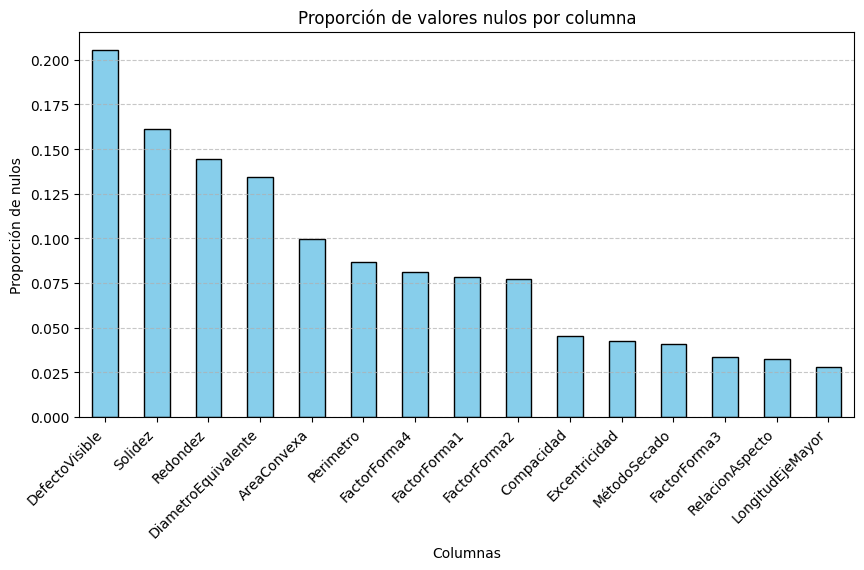

In [107]:

plt.figure(figsize=(10, 5))
resumen_nulos["proporcion"].sort_values(ascending=False).plot(
    kind="bar", color="skyblue", edgecolor="black"
)
plt.title("Proporción de valores nulos por columna")
plt.ylabel("Proporción de nulos")
plt.xlabel("Columnas")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

**DefectoVisible (categorica):** Cuenta con el 20% de los valores nulos. Un valor faltante es ambiguo, no se puede asumir si es normal o defectuoso el grano. Se podria crear una nueva categoria llamada 'Indeterminado' para evitar asunciones falsas y conservar el hecho de que el 20% de los granos no cuetan con un registro de defecto visible. Otra posibilidad es que solo se registren los granos normales y los defectuosos se marquen como nan, mas adelante se evaluará este caso.

**MétodoSecado (categorica):** Cuenta con 4% de datos nulos. Es un dato que no se deriva de un análisis visual de un grano. Como todos los granos de café pasan por un método de secado, no se puede añadir una nueva categoria, por lo que valores nulos se asemejan a un error en el registro de los datos. Como se trata de una variable categorica y muy pocos nulos, estos se imputaran con la moda.

**Variables proporciones y relaciones (numéricas):** Solidez, Redondez, Compacidad, Excentricidad, RelaciónAspecto. Estas variables se pueden calcular con otras columnas, si las otras columnas presentan nulos, se podria eliminar el grano debido a falta de muchas caracteristicas nulas (en especifico si la mayoria (>40%) de las caracteristicas medibles son nulas), esto se evaluará en _____. La mayoria presentan proporciones muy bajas de nulos, por lo que imputar con la media no seria un sesgo muy grande en caso de que algunas no se puedan calcular.

**Variables medibles (numéricas):** DiametroEquivalente, AreaConvexa, Perimetro, FactorForma (1-4), LongitudEjeMayor. Estas variables no son calculables, muestran una clara falta de mediciones de ciertos granos. Para resolverlo, se podria imputar con la media dado que hay un % bajo de nulos. Hay que tener cuidado con estas variables debido a que con estos nulos resueltos se podrian calcular la mayoria de variables que representan proporciones y relaciones.


## 1.3 Unicidad
**Propósito:**
Detectar y tratar registros duplicados, que pueden derivar en análisis engañosos o resultados distorsionados.

**Objetivo:**
Establecer cuáles combinaciones de campos definen la identidad de una fila, detectar duplicidades totales o parciales, decidir cómo resolverlas y argumentar esa decisión.

**Preguntas esenciales:**
¿Hay filas idénticas o esenciales duplicadas? ¿Por qué sucedió? ¿Cómo los trato y por qué así?


In [108]:
duplicados = df[df["ID"].duplicated(keep=False)]
# display(duplicados)
print("Número de filas duplicadas basadas en 'ID':", duplicados.shape[0])
print("Porcentaje de filas duplicadas:", (duplicados.shape[0] / df.shape[0]) * 100, "%  ")


Número de filas duplicadas basadas en 'ID': 1360
Porcentaje de filas duplicadas: 9.516478902805963 %  


In [109]:
duplicadas = df[df.duplicated(keep=False)]
# display(duplicadas)
print("Número de filas duplicadas:", duplicadas.shape[0])
print("Porcentaje de filas duplicadas:", (duplicadas.shape[0] / df.shape[0])*100, '%')


Número de filas duplicadas: 922
Porcentaje de filas duplicadas: 6.451612903225806 %


**Resultados:** Hay un 9.52% de filas con el mismo ID (identificador único de cada grando de café). Hay un 6.45% de filas con todas los registros de todas las columnas dúplicados. Esto divide a los registros en 2 grupos, los duplicados exactos y los duplicados no exactos.

**Duplicados exactos:** Se eliminan porque no aportan información nueva al análisis y, por el contrario, pueden sesgar los resultados. Al eliminarlos, se garantiza que cada fila sea única y que los análisis reflejen de mejor manera la realidad de los datos.

**Duplicados no exactos:** Solo cerca del 3 % de los datos tienen este problema de tener el mismo id con información diferente. Como es un porcentaje pequeño, lo mejor es enfocarse en esos casos puntuales y revisarlos con cuidado. Lo ideal sería confirmar la información en la fuente original y decidir cuál registro conservar, o en su defecto aplicar una regla clara (por ejemplo, quedarse con el más completo o el más reciente). Así se mantiene la coherencia de los datos sin perder información valiosa.


## 1.4 Consistencia
**Propósito:**
Asegurar que las relaciones internas entre columnas y registros tienen lógica y coherencia según el dominio o reglas de negocio.

**Objetivo:**
Identificar combinaciones imposibles, secuencias temporales fallidas, sumas que no cuadran, o cualquier contradicción interna entre los datos.

**Preguntas esenciales:**
¿Hay fechas, valores o relaciones que se contradicen? ¿Dónde, cómo, y qué haré al respecto?

**Tipos de consistencia:**
- Consistencia física: Reglas que no se pueden romper
- Consistencia de cálculo: Verificar que las métricas derivadas se puedan recalcular a partir de las métricas base.
- Consistencia de rango lógico: Asegurarse de que las proporciones y relaciones estén dentro de sus rangos teóricos (ej., entre 0 y 1).



### Consistencia física:
|Regla de consistencia|Columnas involucradas|Acción|
|----|----|----|
|El area convexa debe ser mayor o igual que el area del grano|Área, ÁreaConvexa|Representan errores de medición, por lo que lo mejor sea eliminarlas|
|El eje mayor debe ser mayor que el eje menor|LongitudEjeMayor, Longitud eje menor|Son errores de medición, lo mejor seria eliminar estas filas|



### Consistencias de cálculo
|Métrica a verificar|Columnas involucradas|Acción|
|----|----|----|
|RelaciónAspecto| LongitudEjeMayor, LongitudEjeMenor|Lo más posible es que las mediciones base sean las correctas, por lo que lo mejor sea corregir el valor original con el calculado|
|Solidez|Área, ÁreaConvexa|Confiar en las medidas base, corregir el valor con el calculado|
|Redondez|Área, Perímetro| Confiar en las medidas base, corregir el valor con el calculado|


### Consistencia de rango lógico
|Métrica a verificar|Justificación|Acción|
|----|----|----|
|Solidez|Como es la proporción Área/ÁreaConvexa y Área <= ÁreaConvez, el valor debe estar entre 0 y 1|Valores fuera de este rango son imposibles, por lo que se recalculará, y si persiste el error, se tratarán como NaN|
|Redondez|Un círculo perfecto tiene redondez de 1, todas las demás formas tienen valor inferior|Valores fuera de este rango son imposibles, por lo que se recalculará, y si persiste el error, se tratarán como NaN|
|Compacidad|Es la relación DiametroEquivalente / LongitudEjeMayor. No puede ser mayor que la longitud máxima.|Valores fuera de este rango son imposibles, por lo que se recalculará, y si persiste el error, se tratarán como NaN|
|RelaciónAspecto|Es la relación LongitudEjeMayor / LongitudEjeMenor. Como EjeMayor >= EjeMenor, debe ser ≥ 1|Valores fuera de este rango son imposibles, por lo que se recalculará, y si persiste el error, se tratarán como NaN|


### Evaluación de Consistencia

La etapa de consistencia se abordó según las siguientes consideraciones:

- **Consistencia geométrica:** Se definieron reglas sobre relaciones físicas entre variables (ej. área convexa ≥ área), considerándose errores de medición en caso de incumplimiento. En estos casos, se prioriza la recalculación y, si el problema persiste, se marca el registro como nulo para ser tratado posteriormente.

- **Consistencia de cálculo:** Se verificaron métricas dependientes de otras (relación aspecto, solidez, redondez y compacidad), priorizando su recalculo a partir de valores base si se detectan inconsistencias.

- **Consistencia de rango lógico:** Se establecieron intervalos aceptables para variables derivadas; valores fuera de rango se recalculan o, si la inconsistencia persiste, se marcan como nulos.

- **Prioridad en el manejo de inconsistencias:** La estrategia definida es recalcular primero, luego imputar como nulo si el error persiste, y posteriormente tratar estos casos en la etapa de completitud.

- **Registro de incidencias:** Se reconoce la importancia de medir cuántas veces se activan reglas de validación, pero se pospone este análisis hasta el manejo de valores nulos, para evitar sesgos artificiales en los conteos debidos a datos faltantes.

Este enfoque garantiza que el análisis de consistencia sea riguroso, transparente y basado en la conservación máxima de la información relevante del dataset.


## 1.5 Validez
**Propósito:**
Verificar que los datos en cada columna cumplen los formatos, rangos, tipos y restricciones definidos en el diccionario o por el negocio.

**Objetivo:**
Detectar valores inesperados, formatos incorrectos, datos fuera de rango lógico, o errores de tipeo/codificación.

**Preguntas esenciales:**
¿Hay tipos de datos mal asignados? ¿Valores imposibles (ejemplo: fecha ilógica, medida fuera de rango)? ¿Qué reglas de validación usaré para prevenirlo?

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14291 entries, 0 to 14290
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   14291 non-null  object 
 1   Area                 14291 non-null  int64  
 2   Perimetro            13054 non-null  float64
 3   LongitudEjeMayor     13890 non-null  float64
 4   LongitudEjeMenor     14291 non-null  float64
 5   RelacionAspecto      13825 non-null  object 
 6   Excentricidad        13687 non-null  float64
 7   AreaConvexa          12868 non-null  float64
 8   DiametroEquivalente  12368 non-null  float64
 9   Medida               14291 non-null  float64
 10  Solidez              11985 non-null  float64
 11  Redondez             12228 non-null  float64
 12  Compacidad           13641 non-null  float64
 13  FactorForma1         13172 non-null  float64
 14  FactorForma2         13185 non-null  float64
 15  FactorForma3         13813 non-null 

### Variables marcadas como object (posibles categóricas)
Las columnas ID, RelacionAspecto, DefectoVisible y MétodoSecado se guardan como object, el resto se manejan con tipos aceptables según el entendimiento de datos. Se analizan los valores de las columnas mencionadas:

In [111]:
for col in df.select_dtypes(include=["object"]).columns:
    print(f"\nColumna: {col}")
    print(df[col].unique())



Columna: ID
['G006149' 'G007234' 'G007054' ... 'G005391' 'G000861' 'G007271']

Columna: RelacionAspecto
['alargado' 'Alargado' 'Redondeado' 'redondeado' nan]

Columna: DefectoVisible
['Normal' nan 'normal']

Columna: MétodoSecado
['Lavado' 'Natural' 'lavado' nan 'natural' 'Honey' 'honey']


- La columna ID es un identificador único de cada grano, por lo que cualquier combinación no genera problemas.
- En la columna RelacionAspecto, solo se aceptan los valores 'Alargado' y 'Redondeado', por lo que los valores que estan en minúscula se les debe transformar la primer letra a mayúscula.
- En la columna DefectoVisible, se cambian los registros 'normal' a 'Normal'. El otro caso posible ('Defectuoso') no está presente, esto puede deberse a que los registros marcados como nan representan estos datos.
- En la columna MétodoSecado tambien se corrige el error de primer letra minúscula a mayúscula.

### Variables marcadas con int y float (numéricas)

#### Varibles medibles


In [112]:
df[cols_medibles].describe().T.drop(columns=['count','mean','std','25%','50%','75%'])

,min,max
Area,-6.271600e+04,2.546160e+05
Perimetro,-1.012143e+06,1.921685e+06
LongitudEjeMayor,-4.214447e+02,7.388602e+02
LongitudEjeMenor,-2.008387e+02,4.601985e+02
AreaConvexa,-7.842300e+04,2.510820e+05


La medida mínima de las columnas es negativa, esto presenta un claro error en los datos, pues las medidas físicas no pueden ser negativas. Para evitar una perdida de datos, se marcaran como nulos los valores negativos y serán corregidos por la etapa de completitud.

#### Variables proporción

In [113]:
df[cols_proporcionales].describe().T.drop(columns=['count','mean','std','25%','50%','75%'])

,min,max
Excentricidad,-0.835004,0.911423
Solidez,-0.989042,0.994378
Medida,-0.798706,0.866195
Redondez,-0.896861,0.990685
Compacidad,-0.843901,0.987303
FactorForma1,-0.007982,0.010451
FactorForma2,-0.002673,0.003665
FactorForma3,-0.683269,0.974767
FactorForma4,-0.998527,0.999733
DiametroEquivalente,-448.402605,569.374358


Estas columnas presentan una proporción, por lo que es correcto que ningún máximo pase de 1. Por el otro lado, todos los mínimos están por debajo de 0. Esto presenta un claro error de cálculo, por lo que todos estos datos serán marcados como nulos para luego ser recalculados o en su defecto eliminados.

### Evaluación de Validez

En la etapa de validez se analizaron y definieron reglas para asegurar que los datos cumplen con restricciones de tipo, formato y rango según el conocimiento del dominio y el diccionario de datos.

- **Variables categóricas:** Se detectó y corrigió la falta de estandarización en mayúsculas/minúsculas, asegurando que los únicos valores válidos sean 'Alargado', 'Redondeado', 'Normal' (para DefectoVisible) y los presentes en MétodoSecado. Se dedujo que la ausencia de ciertas categorías podría explicarse por registros nulos en los datos.
- **Variables medibles:** Se identificaron valores negativos en medidas físicas, que son imposibles por definición. Estos se marcarán como nulos para ser tratados luego en la etapa de completitud.
- **Variables proporcionales:** Se comprobó que los valores máximos no exceden 1, pero existen valores mínimos negativos, lo cual es incorrecto. Esos valores serán también marcados como nulos para su corrección o tratamiento posterior.

**Prevención futura:**  
Se propuso que, para evitar errores de validez en la recolección y posterior procesamiento de datos, se implementen validaciones automáticas tanto en los formularios de captura como en los pipelines previos al análisis. Específicamente, toda variable medible y categórica debe ser validada antes de aceptar el envío, garantizando que proporciones y otras derivadas nunca caigan fuera de rango o formato.

Esta estrategia permitirá mejorar la calidad y robustez del dataset desde su origen.


In [114]:
# Se inicia el df de 0
df = pd.read_csv('data/Datos_SenecaféAlpes.csv', sep=';')


---

# 2. Preprocesamiento y transformación de variables
## 2.1 Preprocesamiento genérico


### Completitud.1
Se imputara 'Defectuoso' en los registros con nan en la columna 'DefectoVisible'

In [115]:
nulos = df['DefectoVisible'].isnull().sum()
df['DefectoVisible'] = df['DefectoVisible'].fillna('Defectuoso')
print(f"Número de nulos iputados:", nulos)

Número de nulos iputados: 2935


### Completitud.2
Se imputa la moda en los registros nan de la columna 'MétodoSecado'


In [116]:
nulos = df['MétodoSecado'].isnull().sum()
moda_categoria = df['MétodoSecado'].mode()[0]
print(f"\nLa Moda calculada es: {moda_categoria}")
df['MétodoSecado'] = df['MétodoSecado'].fillna(moda_categoria)
print(f"Número de nulos imputados:", nulos)



La Moda calculada es: Lavado
Número de nulos imputados: 587


### Validez.1
Se corrige el uso de minusculas y mayusculas en la primera letra de las variables 'RelacionAspecto', 'DefectoVisible', 'MétodoSecado'

In [117]:
columnas_a_modificar = ['RelacionAspecto', 'DefectoVisible', 'MétodoSecado']

total_cambios = 0
for columna in columnas_a_modificar:
    columna_antes = df[columna].copy()
    df[columna] = df[columna].str.title()
    cambios_en_columna = (columna_antes.notna() & (columna_antes != df[columna])).sum()

    print(f"Columna '{columna}': {cambios_en_columna} valores modificados.")
    total_cambios += cambios_en_columna


Columna 'RelacionAspecto': 39 valores modificados.
Columna 'DefectoVisible': 2260 valores modificados.
Columna 'MétodoSecado': 2741 valores modificados.


### Validez.2
Se imputaran los valores negativos de las variables medibles con nan para que sean manejables en la etapa de completitud

In [118]:
valores_negativos_antes = df[cols_medibles] < 0
total_a_imputar = valores_negativos_antes.sum().sum()

df.loc[:, cols_medibles] = df[cols_medibles].apply(
    lambda x: np.where(x < 0, np.nan, x)
)

print(f"Número total de valores negativos imputados con nan: {total_a_imputar}")

Número total de valores negativos imputados con nan: 22


C:\Users\juanf\AppData\Local\Temp\ipykernel_38756\2215540283.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[50836. 62764. 59965. ... 90004. 38426. 63628.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, cols_medibles] = df[cols_medibles].apply(


### Validez.3
Se imputaran los valores negativos de las variables que representan proporciones con nan para que sean manejables en la etapa de completitud

In [119]:
valores_negativos_antes = df[cols_proporcionales] < 0
total_a_imputar = valores_negativos_antes.sum().sum()

df.loc[:, cols_proporcionales] = df[cols_proporcionales].apply(
    lambda x: np.where(x < 0, np.nan, x)
)

print(f"Número total de valores negativos imputados con nan: {total_a_imputar}")

Número total de valores negativos imputados con nan: 46


### Unicidad.1
Se eliminan las filas duplicadas exactamente, solo se deja un registro


In [120]:
dupicados = df.duplicated(keep=False).sum()
df.drop_duplicates(keep='first', inplace=True)
print("Número de filas duplicadas exactamente:", dupicados)

Número de filas duplicadas exactamente: 1340


### Unicidad.2
Se eliminan las filas con ids duplicados, se fusionan las filas duplicadas usando la media para variables numéricas y el último registro para las variables catogoricas.

In [121]:
registros_originales = len(df)

agregaciones = {}
for col in cols_medibles + cols_proporcionales:
    agregaciones[col] = 'mean'
for col in cols_categoricas:
    agregaciones[col] = 'last'

df = df.groupby(cols_id, as_index=False).agg(agregaciones)

registros_despues_fusion = len(df)
registros_eliminados = registros_originales - registros_despues_fusion

conteo_ids = df['ID'].value_counts()
ids_editados = conteo_ids[conteo_ids > 1].index
num_registros_editados = len(ids_editados)

print(f"Registros originales: {registros_originales}")
print(f"Registros después de la fusión: {registros_despues_fusion}")
print(f"Total de registros eliminados (colapsados): {registros_eliminados}")
print(f"Total de registros editados (ID único fusionado): {num_registros_editados}")

Registros originales: 13621
Registros después de la fusión: 13611
Total de registros eliminados (colapsados): 10
Total de registros editados (ID único fusionado): 0


In [122]:
resumen_nulos = pd.DataFrame({
    "nulos": df[cols_medibles].isnull().sum(),
    "proporcion": df[cols_medibles].isnull().mean()
})

resumen_nulos = resumen_nulos[resumen_nulos["nulos"] > 0]
print("Cantidad de columnas medibles con valores nulos:", resumen_nulos.shape[0])
print(resumen_nulos.sort_values(by="proporcion", ascending=False))

Cantidad de columnas medibles con valores nulos: 5
                  nulos  proporcion
AreaConvexa        1370    0.100654
Perimetro          1187    0.087209
LongitudEjeMayor    387    0.028433
Area                  3    0.000220
LongitudEjeMenor      3    0.000220


Para evitar una gran perdida de datos, se intentará calcular el AreaConvexa y el Perímetro para ver como varia la cantidad de nulos. Esto no se hace con las otras variables para manejar posibles errores de los otros estadísticos.

In [123]:
# Rellenar AreaConvexa usando Área y Solidez
mask_area_convexa = df['AreaConvexa'].isna() & df['Area'].notna() & df['Solidez'].notna()
df.loc[mask_area_convexa, 'AreaConvexa'] = (
    df.loc[mask_area_convexa, 'Area'] / df.loc[mask_area_convexa, 'Solidez']
)

# Rellenar Perimetro usando Área y Redondez
mask_perimetro = df['Perimetro'].isna() & df['Area'].notna() & df['Redondez'].notna()
df.loc[mask_perimetro, 'Perimetro'] = np.sqrt(
    (4 * np.pi * df.loc[mask_perimetro, 'Area']) / df.loc[mask_perimetro, 'Redondez']
)


In [124]:
resumen_nulos = pd.DataFrame({
    "nulos": df[cols_medibles].isnull().sum(),
    "proporcion": df[cols_medibles].isnull().mean()
})

resumen_nulos = resumen_nulos[resumen_nulos["nulos"] > 0]
print("Cantidad de columnas medibles con valores nulos:", resumen_nulos.shape[0])
print(resumen_nulos.sort_values(by="proporcion", ascending=False))

Cantidad de columnas medibles con valores nulos: 5
                  nulos  proporcion
LongitudEjeMayor    387    0.028433
AreaConvexa         213    0.015649
Perimetro           159    0.011682
Area                  3    0.000220
LongitudEjeMenor      3    0.000220


In [125]:
columnas_con_nulos = ['LongitudEjeMayor', 'AreaConvexa', 'Perimetro', 'Area', 'LongitudEjeMenor']

filas_antes = len(df)
df_limpio = df.dropna(subset=columnas_con_nulos)
filas_eliminadas = filas_antes - len(df_limpio)

print(f"Se eliminaron {filas_eliminadas} filas con valores nulos.")
print(f"El DataFrame ahora tiene {len(df_limpio)} filas.")

Se eliminaron 755 filas con valores nulos.
El DataFrame ahora tiene 12856 filas.


In [126]:
df_limpio[cols_medibles
          ].isnull().sum()
df = df_limpio

### Completitud.3
Como las variables medibles ya no tienen nulos, se pueden calcular el resto de variables que representan proporciones, pero primero se verificará rápidamente que las reglas planteadas guarden consistencia con los dats

In [127]:
#Regas
def calc_relacion_aspecto(serie):
    # if serie['RelacionAspecto'] is not np.nan:
    #     return serie['RelacionAspecto']
    if serie['LongitudEjeMenor'] and serie['LongitudEjeMayor']:
        return 'Alargado' if (serie['LongitudEjeMenor'] / serie['LongitudEjeMayor'])<1.3 else 'Redondeado'
    return np.nan

def calc_excentricidad(serie):
    # if serie['Excentricidad'] is not np.nan:
    #     return serie['Excentricidad']
    if serie['LongitudEjeMenor'] and serie['LongitudEjeMayor']:
        a = serie['LongitudEjeMayor'] / 2
        b = serie['LongitudEjeMenor'] / 2
        return np.sqrt(1 - (b**2 / a**2))
    return np.nan

def calc_diametro_equivalente(serie):
    # if serie['DiametroEquivalente'] is not np.nan:
    #     return serie['DiametroEquivalente']
    if serie['Area']:
        return np.sqrt(4 * serie['Area'] / np.pi)
    return np.nan

def calc_medida(serie):
    # if pd.notna(serie.get("Medida", np.nan)):
    #     return serie["Medida"]
    if pd.notna(serie.get("Area", np.nan)) and pd.notna(serie.get("LongitudEjeMayor", np.nan)) and pd.notna(serie.get("LongitudEjeMenor", np.nan)):
        bounding_box_area = serie["LongitudEjeMayor"] * serie["LongitudEjeMenor"]
        if bounding_box_area > 0:
            return serie["Area"] / bounding_box_area
    return np.nan

def calc_solidez(serie):
    # if serie['Solidez'] is not np.nan:
    #     return serie['Solidez']
    if serie['AreaConvexa'] and serie['Area']:
        return serie['Area'] / serie['AreaConvexa']
    return np.nan

def calc_redondez(serie):
    # if serie['Redondez'] is not np.nan:
    #     return serie['Redondez']
    if serie['Area'] and serie['Perimetro']:
        return (4 * np.pi * serie['Area']) / (serie['Perimetro'] ** 2)
    return np.nan

def calc_compacidad(serie):
    # if serie['Compacidad'] is not np.nan:
    #     return serie['Compacidad']
    if serie['DiametroEquivalente'] and serie['LongitudEjeMayor']:
        return serie['DiametroEquivalente'] / serie['LongitudEjeMayor']
    return np.nan

In [128]:
df_prueba = df.copy()


def comparar_columnas(df, col1, col2, tol=1e-5):
    """
    Compara dos columnas de un DataFrame:
    - Si son strings: igualdad exacta
    - Si son numéricas: similitud con tolerancia
    - Devuelve una Serie booleana con True/False/NaN
    """
    s1, s2 = df[col1], df[col2]
    
    resultado = []
    for a, b in zip(s1, s2):
        # Caso ambos NaN
        if pd.isna(a) and pd.isna(b):
            resultado.append(np.nan)
        # Caso NaN en uno solo
        elif pd.isna(a) or pd.isna(b):
            resultado.append(False)
        # Caso strings
        elif isinstance(a, str) or isinstance(b, str):
            resultado.append(str(a) == str(b))
        # Caso numérico
        else:
            try:
                resultado.append(np.isclose(float(a), float(b), rtol=tol, atol=tol))
            except:
                resultado.append(False)
    
    return pd.Series(resultado, index=df.index)


In [129]:
funciones = {
    "RelacionAspecto": calc_relacion_aspecto,
    "Excentricidad": calc_excentricidad,
    "DiametroEquivalente": calc_diametro_equivalente,
    "Medida": calc_medida,
    "Solidez": calc_solidez,
    "Redondez": calc_redondez,
    "Compacidad": calc_compacidad
}

for i in funciones.items():
    nombre_col, funcion = i
    df_prueba[f"{nombre_col}_calc"] = df_prueba.apply(funcion, axis=1)
    print(f"Comparando {nombre_col} con {nombre_col}_calc:")
    print(comparar_columnas(df_prueba, nombre_col, f"{nombre_col}_calc").value_counts(dropna=False))
    print("\n")
    pass

# df_prueba['RelacionAspecto_calc'] = df_prueba.apply(calc_relacion_aspecto, axis=1)
# comparar_columnas(df_prueba, 'RelacionAspecto', 'RelacionAspecto_calc').value_counts(dropna=False)

Comparando RelacionAspecto con RelacionAspecto_calc:
True     10858
False     1998
Name: count, dtype: int64


Comparando Excentricidad con Excentricidad_calc:
True     12309
False      547
Name: count, dtype: int64


Comparando DiametroEquivalente con DiametroEquivalente_calc:
True     11135
False     1721
Name: count, dtype: int64


Comparando Medida con Medida_calc:
False    12853
True         3
Name: count, dtype: int64


Comparando Solidez con Solidez_calc:
True     10956
False     1900
Name: count, dtype: int64


Comparando Redondez con Redondez_calc:
False    10880
True      1976
Name: count, dtype: int64


Comparando Compacidad con Compacidad_calc:
True     10621
False     2161
NaN         74
Name: count, dtype: int64




Las columnas 'RelacionAspecto', 'Excentricidad', 'Compacidad', 'DiametroEquivalente' y 'Solidez' muestran la mayoria de los datos consistentes con el cálculadas, por lo que estas se pueden imputar.

In [130]:
dict_imputables = {'RelacionAspecto':calc_relacion_aspecto,
                   'Excentricidad':calc_excentricidad,
                   'Solidez':calc_solidez,
                   'DiametroEquivalente':calc_diametro_equivalente,
                    "Compacidad": calc_compacidad
}

for i in dict_imputables.items():
    nombre_col, funcion = i
    mask_nulos = df[nombre_col].isna()
    n_nulos_antes = mask_nulos.sum()
    df.loc[mask_nulos, nombre_col] = df[mask_nulos].apply(funcion, axis=1)
    n_nulos_despues = df[nombre_col].isna().sum()
    print(f"Columna '{nombre_col}': {n_nulos_antes - n_nulos_despues} valores imputados.")
    pass

Columna 'RelacionAspecto': 413 valores imputados.
Columna 'Excentricidad': 547 valores imputados.
Columna 'Solidez': 1900 valores imputados.
Columna 'DiametroEquivalente': 1721 valores imputados.
Columna 'Compacidad': 588 valores imputados.


Damos más espacio de comparación (con tol=0.001) para las otras variables

In [131]:
funciones = {
    "Medida": calc_medida,
    "Redondez": calc_redondez,
}

for i in funciones.items():
    nombre_col, funcion = i
    df[f"{nombre_col}_calc"] = df.apply(funcion, axis=1)
    print(f"Comparando {nombre_col} con {nombre_col}_calc:")
    print(comparar_columnas(df, nombre_col, f"{nombre_col}_calc", tol=0.1).value_counts(dropna=False))
    print("\n")
    df.drop(columns=[f"{nombre_col}_calc"], inplace=True)
    pass

Comparando Medida con Medida_calc:
True     12737
False      119
Name: count, dtype: int64


Comparando Redondez con Redondez_calc:
False    10880
True      1976
Name: count, dtype: int64




Como solo medida se marcó la mayoria como True, este se imputará con la medida calculada

In [132]:
funciones = {
    "Medida": calc_medida,
}


for i in funciones.items():
    nombre_col, funcion = i
    mask_nulos = df[nombre_col].isna()
    n_nulos_antes = mask_nulos.sum()
    df.loc[mask_nulos, nombre_col] = df[mask_nulos].apply(funcion, axis=1)
    n_nulos_despues = df[nombre_col].isna().sum()
    print(f"Columna '{nombre_col}': {n_nulos_antes - n_nulos_despues} valores imputados.")
    pass

Columna 'Medida': 1 valores imputados.


In [133]:
funciones = {
    "Redondez": calc_redondez,
}

for i in funciones.items():
    nombre_col, funcion = i
    df[f"{nombre_col}_calc"] = df.apply(funcion, axis=1)
    print(f"Comparando {nombre_col} con {nombre_col}_calc:")
    print(comparar_columnas(df, nombre_col, f"{nombre_col}_calc", tol=0.1).value_counts(dropna=False))
    print("\n")
    df.drop(columns=[f"{nombre_col}_calc"], inplace=True)

    pass

Comparando Redondez con Redondez_calc:
False    10880
True      1976
Name: count, dtype: int64




In [134]:
resumen_nulos = pd.DataFrame({
    "nulos": df.isnull().sum(),
    "proporcion": df.isnull().mean()
})

resumen_nulos = resumen_nulos[resumen_nulos["nulos"] > 0]
print("Cantidad de columnas con valores nulos:", resumen_nulos.shape[0])
print(resumen_nulos.sort_values(by="proporcion", ascending=False))


Cantidad de columnas con valores nulos: 5
              nulos  proporcion
Redondez       1738    0.135190
FactorForma4   1051    0.081752
FactorForma1   1012    0.078718
FactorForma2    990    0.077007
FactorForma3    438    0.034070


In [135]:
#TODO Desicion Redondez

### Entendimiento de datos.1
Se cambian los tipos de datos de las columnas categoricas y se elimina el id


In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12856 entries, 0 to 13610
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   12856 non-null  object 
 1   Area                 12856 non-null  float64
 2   Perimetro            12856 non-null  float64
 3   LongitudEjeMayor     12856 non-null  float64
 4   LongitudEjeMenor     12856 non-null  float64
 5   AreaConvexa          12856 non-null  float64
 6   Excentricidad        12856 non-null  float64
 7   Solidez              12856 non-null  float64
 8   Medida               12856 non-null  float64
 9   Redondez             11118 non-null  float64
 10  Compacidad           12856 non-null  float64
 11  FactorForma1         11844 non-null  float64
 12  FactorForma2         11866 non-null  float64
 13  FactorForma3         12418 non-null  float64
 14  FactorForma4         11805 non-null  float64
 15  DiametroEquivalente  12856 non-null  floa

In [137]:
df = df.astype({col: "string" for col in df.select_dtypes(include="object").columns})
df = df.drop(columns=['ID'])
df.dtypes


Area                          float64
Perimetro                     float64
LongitudEjeMayor              float64
LongitudEjeMenor              float64
AreaConvexa                   float64
Excentricidad                 float64
Solidez                       float64
Medida                        float64
Redondez                      float64
Compacidad                    float64
FactorForma1                  float64
FactorForma2                  float64
FactorForma3                  float64
FactorForma4                  float64
DiametroEquivalente           float64
DefectoVisible         string[python]
MétodoSecado           string[python]
RelacionAspecto        string[python]
dtype: object

### Unicidad.3
Verificamos por última vez si hay filas duplicadas

In [138]:
dupli = df.duplicated().sum()
print(f"Se encontraron {dupli} filas duplicadas.")

Se encontraron 6 filas duplicadas.


Se encontraron 6 filas duplicadas, como estas no aportan datos nuevos al modelo, se puede tratar de un mismo grano evaluado 2 veces y registrado con diferente ID. se eliminan.

In [139]:
df = df.drop_duplicates(keep='first')
dupli_ = df.duplicated().sum()
print(f"Se encontraron {dupli} filas duplicadas y se eliminaron. Ahora quedan {dupli_} filas duplicadas.")

Se encontraron 6 filas duplicadas y se eliminaron. Ahora quedan 0 filas duplicadas.


### Outliders.1

Se identifican valores muy cercanos extraños para la columna perímetro, estos se tratan como outliders y se eliminan.

In [140]:
col = "Perimetro"
Q1 = df[col].quantile(0.25)
Q3 = df[col].quantile(0.75)
IQR = Q3 - Q1

lim_inf = Q1 - 1.5 * IQR
lim_sup = Q3 + 1.5 * IQR

outliers = df[(df[col] < lim_inf) | (df[col] > lim_sup)]
print("Cantidad de outliers:", len(outliers))
df_clean = df[~((df[col] < lim_inf) | (df[col] > lim_sup))]
df = df_clean


Cantidad de outliers: 2537


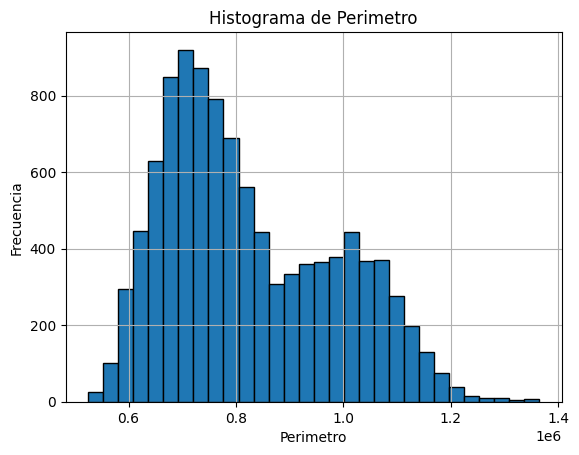

In [141]:
df["Perimetro"].hist(bins=30, edgecolor="black")
plt.xlabel("Perimetro")
plt.ylabel("Frecuencia")
plt.title("Histograma de Perimetro")
plt.show()


### Outliders.2
Se identifican outliders en las columnas medibles importantes del caso y se eliminan

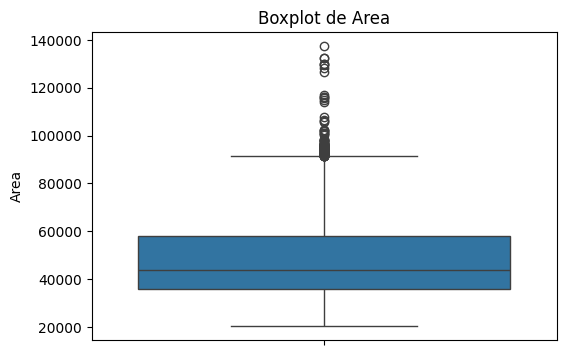

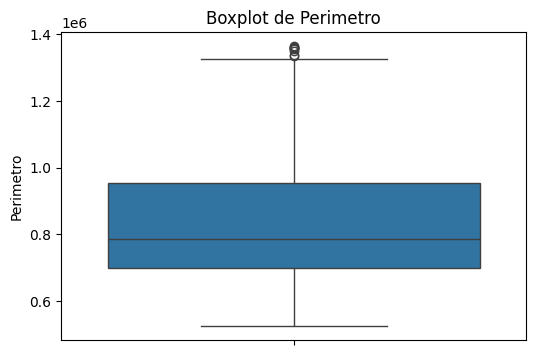

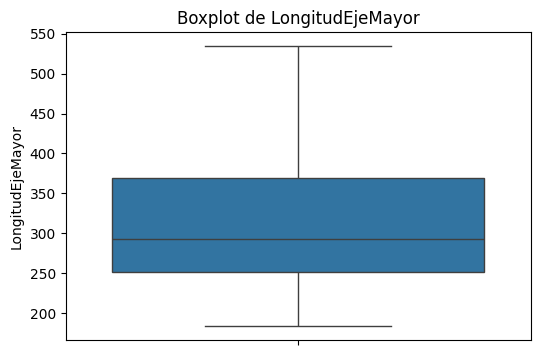

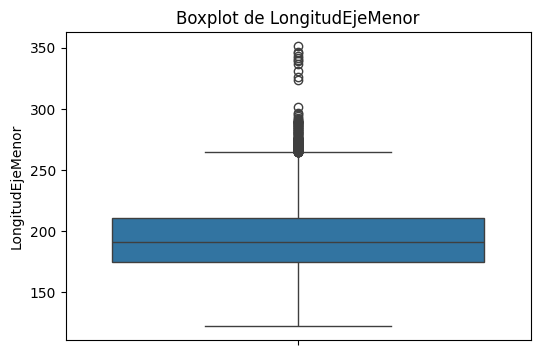

In [142]:
cols = ["Area", "Perimetro", "LongitudEjeMayor", "LongitudEjeMenor"]

for col in cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, y=col)
    plt.title(f"Boxplot de {col}")
    plt.show()

In [143]:
import pandas as pd

# Lista de columnas numéricas donde quieres eliminar outliers
# cols = ["col1", "col2", "col3"]

# Copiamos el df para no dañar el original
df_clean = df.copy()

for col in cols:
    Q1 = df_clean[col].quantile(0.25)   # Primer cuartil
    Q3 = df_clean[col].quantile(0.75)   # Tercer cuartil
    IQR = Q3 - Q1                       # Rango intercuartílico

    # Límites para detectar outliers
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # Filtrar los datos dentro de los límites
    df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]

df = df_clean

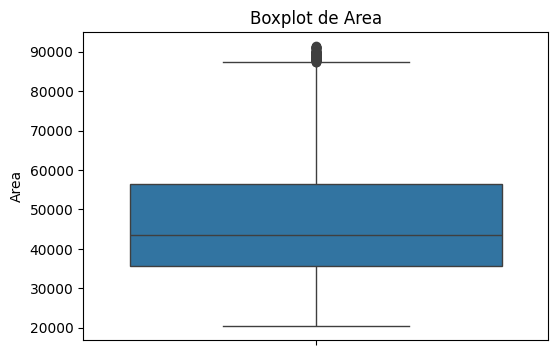

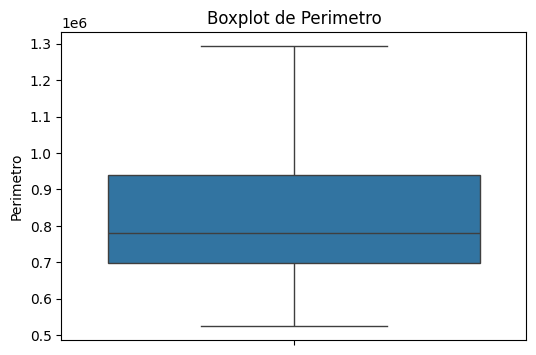

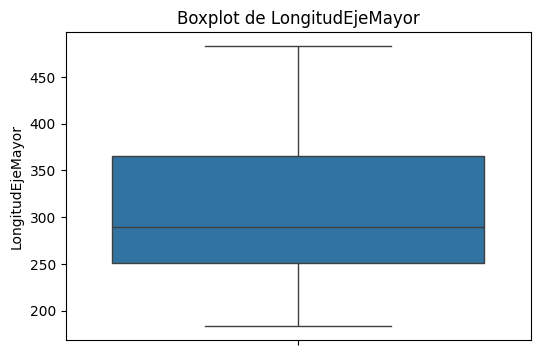

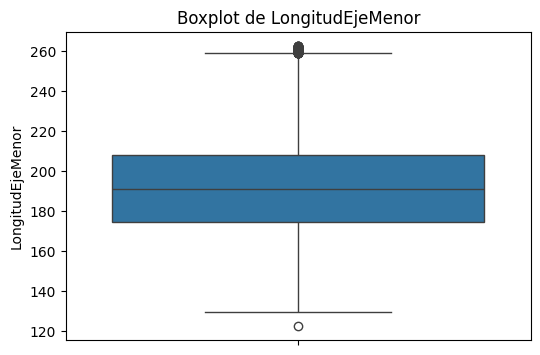

In [144]:
for col in cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, y=col)
    plt.title(f"Boxplot de {col}")
    plt.show()

## Conclusión
Con estos pasos se termina el proceso de limpieza, variables como FactorForma (1-4) aún quedan con nulos, pero estos se tratarán en el preprocesamiento específico de cada algoritmo a utilizar


## 2.2 Preprocesamiento específico y algoritmo
### 2.2.1 Algoritmo 1 : K-means

#### Limpieza específica

In [145]:
df_alg1 = df.copy()
df_alg1.drop(columns=cols_proporcionales + ['AreaConvexa', 'RelacionAspecto'], inplace=True)
# df_alg1.drop(columns= ['AreaConvexa'], inplace=True)
df_alg1

,Area,Perimetro,LongitudEjeMayor,LongitudEjeMenor,DefectoVisible,MétodoSecado
0,28395.0,610291.0,208.178117,173.888747,Normal,Lavado
1,28734.0,638018.0,200.524796,182.734419,Normal,Lavado
3,30008.0,645884.0,210.557999,182.516516,Normal,Lavado
4,30140.0,620134.0,201.847882,190.279279,Normal,Lavado
6,30477.0,670033.0,211.050155,184.039050,Normal,Lavado
...,...,...,...,...,...,...
13606,42097.0,759696.0,288.721612,185.944705,Normal,Natural
13607,42101.0,757499.0,281.576392,190.713136,Normal,Lavado
13608,42139.0,759321.0,281.539928,191.187979,Normal,Natural
13609,42147.0,763779.0,283.382636,190.275731,Normal,Natural


In [151]:
numeric_cols = ['Area', 'Perimetro', 'LongitudEjeMayor', 'LongitudEjeMenor']
categorical_cols = ['DefectoVisible', 'MétodoSecado']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ])

df_processed = preprocessor.fit_transform(df_alg1)
df_processed

array([[-1.2246649 , -1.37062259, -1.51251123, ...,  1.        ,
         1.        ,  0.        ],
       [-1.20262329, -1.18715303, -1.6305549 , ...,  1.        ,
         1.        ,  0.        ],
       [-1.11978845, -1.13510371, -1.47580428, ...,  1.        ,
         1.        ,  0.        ],
       ...,
       [-0.33103691, -0.3844911 , -0.38098971, ...,  1.        ,
         0.        ,  1.        ],
       [-0.33051675, -0.35499251, -0.35256805, ...,  1.        ,
         0.        ,  1.        ],
       [-0.32973652, -0.29902592, -0.17118197, ...,  1.        ,
         1.        ,  0.        ]], shape=(10078, 7))

#### Modelo

In [147]:
param_grid = {
    'n_clusters': range(2, 5),
    'init': ['k-means++', 'random'],
    'n_init': [10, 20]
}

best_score_kmeans = -1
best_params_kmeans = {}
results_kmeans = []

for k in param_grid['n_clusters']:
    for init in param_grid['init']:
        for n_init in param_grid['n_init']:
            kmeans = KMeans(n_clusters=k, init=init, n_init=n_init, random_state=42)
            labels = kmeans.fit_predict(df_processed)
            score = silhouette_score(df_processed, labels)
            
            results_kmeans.append({
                'n_clusters': k,
                'init': init,
                'n_init': n_init,
                'silhouette_score': score
            })
            
            print(f"k={k}, init={init}, n_init={n_init}: Silhouette Score = {score:.4f}")
            
            if score > best_score_kmeans:
                best_score_kmeans = score
                best_params_kmeans = {'n_clusters': k, 'init': init, 'n_init': n_init}
                best_kmeans_model = kmeans  # Guardar el modelo
                best_kmeans_labels = labels  # Guardar las labels

print("\nMejores parámetros para KMeans:")
print(best_params_kmeans)
print(f"Mejor Silhouette Score: {best_score_kmeans:.4f}")
print(f"Distribución de clusters: {np.bincount(best_kmeans_labels)}")

k=2, init=k-means++, n_init=10: Silhouette Score = 0.4862
k=2, init=k-means++, n_init=20: Silhouette Score = 0.4862
k=2, init=random, n_init=10: Silhouette Score = 0.4866
k=2, init=random, n_init=20: Silhouette Score = 0.4866
k=3, init=k-means++, n_init=10: Silhouette Score = 0.3464
k=3, init=k-means++, n_init=20: Silhouette Score = 0.3467
k=3, init=random, n_init=10: Silhouette Score = 0.3464
k=3, init=random, n_init=20: Silhouette Score = 0.3464
k=4, init=k-means++, n_init=10: Silhouette Score = 0.3239
k=4, init=k-means++, n_init=20: Silhouette Score = 0.3246
k=4, init=random, n_init=10: Silhouette Score = 0.3233
k=4, init=random, n_init=20: Silhouette Score = 0.3234

Mejores parámetros para KMeans:
{'n_clusters': 2, 'init': 'random', 'n_init': 10}
Mejor Silhouette Score: 0.4866
Distribución de clusters: [6853 3225]


#### Ver clusters

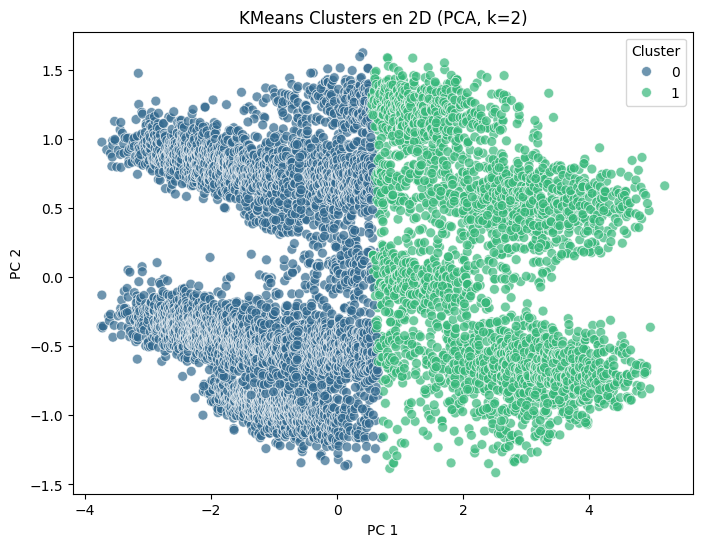

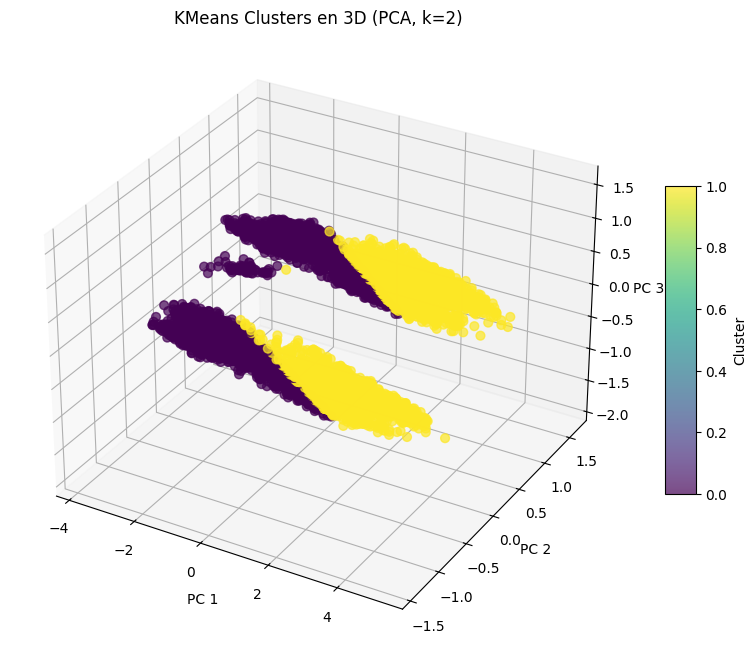

In [148]:
# --- Reducir a 2D y 3D con PCA ---
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(df_processed)

pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(df_processed)

# --- Gráfico 2D ---
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_pca_2d[:,0], 
    y=X_pca_2d[:,1], 
    hue=best_kmeans_labels, 
    palette="viridis", 
    s=50, alpha=0.7
)
plt.title(f"KMeans Clusters en 2D (PCA, k={best_params_kmeans['n_clusters']})")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend(title="Cluster")
plt.show()

# --- Gráfico 3D ---
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_pca_3d[:,0], 
    X_pca_3d[:,1], 
    X_pca_3d[:,2], 
    c=best_kmeans_labels, 
    cmap="viridis", 
    s=40, alpha=0.7
)

ax.set_title(f"KMeans Clusters en 3D (PCA, k={best_params_kmeans['n_clusters']})")
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")

fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=10, label="Cluster")
plt.show()


#### Conclusión
Aunque el modelo de KMeans con dos clusters alcanzó un Silhouette Score aceptable (0.4866) y encontró una partición binaria en los datos, su desempeño no resulta del todo satisfactorio. Al analizar la proyección en 3D mediante PCA, se observa que la estructura real de los datos parece mostrar más de dos agrupaciones diferenciadas, mientras que el algoritmo solo identifica una separación básica en dos bloques. Esto sugiere que KMeans no logra capturar adecuadamente la complejidad de la distribución, lo que limita su capacidad explicativa y hace necesario explorar otros modelos de clustering más flexibles que podrían reflejar con mayor precisión la verdadera segmentación de los datos.

### Algoritmo 2


In [149]:
df_alg2 = df.copy()

### 2.2.3 Algoritmo 3 : HDBSCAN

#### Limpieza específica

In [7]:
if "DiametroEquivalente" in cols_proporcionales:
    cols_proporcionales = [c for c in cols_proporcionales if c != "DiametroEquivalente"]
    if "DiametroEquivalente" not in cols_medibles:
        cols_medibles = cols_medibles + ["DiametroEquivalente"]

df3 = df.drop_duplicates().copy()

# Numéricas "medibles": to_numeric + imputación mediana
for c in cols_medibles:
    if c in df3.columns:
        df3[c] = pd.to_numeric(df3[c], errors="coerce").fillna(df3[c].median())

# Proporcionales: quitar "%", mapear 45 -> 0.45 si procede, clip a [0,1], imputar mediana
for c in cols_proporcionales:
    if c in df3.columns:
        x = df3[c].astype(str).str.replace("%","",regex=False)
        x = pd.to_numeric(x, errors="coerce")
        x = np.where((x>1)&(x<=100), x/100.0, x)
        df3[c] = pd.Series(np.clip(x, 0, 1), index=df3.index).fillna(np.nanmedian(x))

# Categóricas: tratar "" como NA y rellenar por moda
def _mode_safe(s: pd.Series):
    m = s.mode(dropna=True)
    return m.iloc[0] if not m.empty else np.nan

for c in cols_categoricas:
    if c in df3.columns:
        s = df3[c].astype("string").str.strip().replace({"": pd.NA})
        df3[c] = s.fillna(_mode_safe(s)).astype("category")

# Columnas finales para el modelo
all_cols = [c for c in (cols_medibles+cols_proporcionales+cols_categoricas) if c in df3.columns]
X3_clean = df3[all_cols].copy()
a3_cols_medibles, a3_cols_proporcionales, a3_cols_categoricas = cols_medibles, cols_proporcionales, cols_categoricas

#### Modelo

In [13]:
X_model = X3_clean
n = len(X_model)

# Máscara de categóricas alineada
cat_mask = [c in a3_cols_categoricas for c in X_model.columns]

# 1) Distancias de Gower
D_gower = gower.gower_matrix(X_model, cat_features=cat_mask)

# FIXES críticos para HDBSCAN con 'precomputed':
# a) dtype: float64 (double) y C-contiguo
D_gower = np.asarray(D_gower, dtype=np.float64, order="C")
# b) simetría numérica y diagonal cero
D_gower = 0.5 * (D_gower + D_gower.T)
np.fill_diagonal(D_gower, 0.0)
# c) límites y finitud
D_gower = np.clip(D_gower, 0.0, 1.0)
if not np.isfinite(D_gower).all():
    raise ValueError("D_gower contiene NaN/Inf tras el cálculo; revisa datos de entrada.")

print(f"[INFO] Gower: {D_gower.shape} | dtype={D_gower.dtype} | min={D_gower.min():.3f} | max={D_gower.max():.3f}")

# 2) HDBSCAN (baseline)
min_cs = max(10, int(np.sqrt(n)))
clusterer_3 = hdbscan.HDBSCAN(
    metric='precomputed',
    min_cluster_size=min_cs,
    min_samples=min_cs,
    cluster_selection_method='eom'
)
labels_3 = clusterer_3.fit_predict(D_gower)

# 3) Métricas
unique_labels = np.unique(labels_3)
n_clusters = (unique_labels != -1).sum()
noise_pct = (labels_3 == -1).mean() * 100

silhouette = None
mask = labels_3 != -1
if n_clusters >= 2 and mask.sum() >= 2:
    D_nn = D_gower[np.ix_(mask, mask)]
    silhouette = silhouette_score(D_nn, labels_3[mask], metric='precomputed')

print("Resumen HDBSCAN + Gower:")
print(f"Clusters (excluye ruido): {n_clusters}")
print(f"Ruido: {noise_pct:.1f}%")
print(f"Silhouette (no-ruido): {silhouette if silhouette is not None else 'N/A'}")
print("Persistencias:", getattr(clusterer_3, "cluster_persistence_", None))

# 4) Tamaños por cluster
sizes = (
    pd.Series(labels_3, name="cluster")
      .value_counts(dropna=False)
      .rename_axis("cluster")
      .reset_index(name="count")
      .sort_values("cluster")
)
display(sizes)

[INFO] Gower: (13830, 13830) | dtype=float64 | min=0.000 | max=0.468
Resumen HDBSCAN + Gower:
Clusters (excluye ruido): 9
Ruido: 6.6%
Silhouette (no-ruido): 0.5084392042253216
Persistencias: [0.14269695 0.17270214 0.17737414 0.40450203 0.30106181 0.01303259
 0.02748502 0.25559592 0.0145078 ]


,cluster,count
3,-1,915
6,0,237
5,1,906
4,2,906
2,3,1203
1,4,4325
9,5,153
7,6,180
0,7,4849
8,8,156


#### Ver clusters

In [16]:
# Resumen mínimo
labels = np.asarray(labels_3)
sizes = (pd.Series(labels, name="cluster")
         .value_counts(dropna=False)
         .sort_index())

# Persistencias (solo clusters válidos, excluye -1)
valid = sorted(set(labels) - {-1})
persistence = pd.Series(getattr(clusterer_3, "cluster_persistence_", []),
                        index=valid, name="persistence")

summary_df = (pd.DataFrame({"count": sizes, "pct": (sizes/len(labels)).round(4)})
              .join(persistence, how="left"))
print("Resumen de clusters:")
display(summary_df)

Resumen de clusters:


,count,pct,persistence
cluster,,,
-1,915,0.0662,NaN
0,237,0.0171,0.142697
1,906,0.0655,0.172702
2,906,0.0655,0.177374
3,1203,0.0870,0.404502
4,4325,0.3127,0.301062
5,153,0.0111,0.013033
6,180,0.0130,0.027485
7,4849,0.3506,0.255596


/Users/david/Documents/BI/Laboratorio2BI/Lab2-bi/.venv/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/david/Documents/BI/Laboratorio2BI/Lab2-bi/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


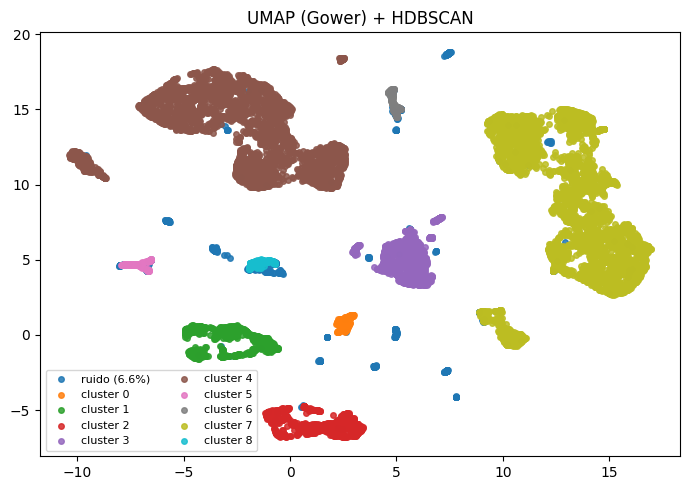

In [20]:
D = np.asarray(D_gower, dtype=np.float64, order="C")  # por si acaso
um = umap.UMAP(metric="precomputed", n_neighbors=15, min_dist=0.1, random_state=42)
xy = um.fit_transform(D)

plt.figure(figsize=(7,5))
labs = np.asarray(labels_3)
for k in np.unique(labs):
    m = labs == k
    lbl = f"cluster {k}" if k != -1 else f"ruido ({(m.sum()/len(m))*100:.1f}%)"
    plt.scatter(xy[m,0], xy[m,1], s=16, alpha=0.85, label=lbl)
plt.title("UMAP (Gower) + HDBSCAN"); plt.legend(fontsize=8, ncol=2)
plt.tight_layout(); plt.show()

In [21]:
# Medianas numéricas por cluster
num_cols = [c for c in (a3_cols_medibles + a3_cols_proporcionales) if c in X3_clean.columns]
medianas = (X3_clean[num_cols]
            .assign(cluster=labels_3)
            .groupby("cluster")
            .median()
            .round(3))
print("Medianas por cluster (numéricas/proporcionales):")
display(medianas)

Medianas por cluster (numéricas/proporcionales):


,Area,Perimetro,LongitudEjeMayor,LongitudEjeMenor,AreaConvexa,DiametroEquivalente,Excentricidad,Solidez,Medida,Redondez,Compacidad,FactorForma1,FactorForma2,FactorForma3,FactorForma4
cluster,,,,,,,,,,,,,,,
-1,74864.0,800234.0,390.164,242.332,57805.0,269.668,0.755,0.988,0.761,0.883,0.806,0.006,0.001,0.652,0.996
0,38445.0,712975.0,245.886,199.493,39488.0,222.763,0.577,0.991,0.775,0.954,0.903,0.006,0.003,0.816,0.999
1,46156.5,774306.0,305.142,188.028,45091.0,238.545,0.775,0.988,0.713,0.878,0.794,0.007,0.002,0.629,0.996
2,44391.5,771879.0,296.485,189.490,45091.0,238.545,0.766,0.988,0.787,0.883,0.800,0.007,0.002,0.640,0.996
3,38495.0,713031.0,244.739,200.678,39347.0,223.080,0.576,0.990,0.777,0.951,0.904,0.006,0.003,0.817,0.999
4,46590.0,777856.0,310.121,186.820,45091.0,238.545,0.778,0.988,0.711,0.879,0.791,0.007,0.002,0.625,0.996
5,47024.0,808532.0,307.057,188.620,45468.0,238.814,0.787,0.988,0.705,0.877,0.787,0.007,0.002,0.614,0.996
6,40363.5,746256.0,275.003,182.991,41378.0,229.810,0.757,0.988,0.786,0.893,0.808,0.007,0.002,0.648,0.997
7,45147.0,771879.0,297.567,189.917,45091.0,238.545,0.764,0.988,0.785,0.883,0.801,0.007,0.002,0.641,0.996


#### Conclusión

Con HDBSCAN + Gower sobre el dataset ((14 291 \times 19)) se identificaron 9 clusters con 6.6 % de puntos marcados como ruido y una silueta ≈ 0.508 (calculada sobre no-ruido), lo que indica una estructura de grupos razonablemente nítida; no obstante, la persistencia por cluster es heterogénea y en varios casos baja (≈ 0.014–0.404), sugiriendo fragilidad o posibles fusiones entre algunos grupos. En conjunto, el modelo resulta adecuado para segmentación inicial en datos mixtos (mejor que k-means en este contexto), pero para fortalecer la estabilidad conviene ajustar min_cluster_size / min_samples (ligeramente al alza), consolidar clusters con persistencia < 0.20 y revisar categorías muy raras que puedan inducir micro-grupos.


---
# 3. Comparación y validación de modelos


---
# 4. Interpretación de resultados


---
# 5. Conclusiones y recomendaciones profesionales


---
# 6. Declaración de colaboración y uso de IA generativa